## Statistical Inference

The different techniques of descriptive statistics that we have covered give us a straightforward presentation of facts from the data.  *Inference* is the process of making propositions and drawing conclusions about a larger population than the sample data represents.  We have three types of inference 

* _Estimation_ of the most appropriate single value of a parameter.
* _Interval estimation_ to assess what region of parameter values is most consistent with the given data.
* _Hypothesis testing_ to decide between two options, what parameter values are most consistent with the data.

There are mainly three approaches to attacking these problems.

* *Frequentist*: Inference is judged based upon performance in repeated sampling.
* *Bayesian*: Inference must be subjective.  A prior distribution is chosen for the parameter we seek, and we combine the density of the data with the prior to obtain a joint distribution.  A further application of Bayes Theorem gives us a distribution of the parameter, given the data.  To perform computations in this setting, we use the package `PyMC`.
* *Likelihood*: Inference is based on the fact that all information about the parameter may be obtained by inspection of a _likelihood_ function, which is proportional to the probability density function.

In this section we will briefly illustrate the three approaches to each of the three inference types.  We go back to the previous example of ratios of daily complaints of mortgages against credit cards.

In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt

%matplotlib inline

data = pd.read_csv("Consumer_Complaints.csv", low_memory=False, parse_dates=[8,9])

df = data.groupby(['Date received', 'Product']).size().unstack()
ratios = df['Mortgage'] / df['Credit card']

ratios.describe()

count    1001.000000
mean        2.939686
std         1.341827
min         0.203947
25%         1.985507
50%         2.806452
75%         3.729167
max        12.250000
dtype: float64

By visual inspection of the histogram, we could very well assume that this data is a random sample from a normal distribution with parameters $\mu$ (average) and $\sigma$ (standard deviation).  We further assume, for simplicity, that the scale parameter $\sigma$ is known, and its value is `1.3`.  

> Later in this section, we will actually explore what tools we have in the `scipy` stack to determine more precisely the distribution of data.

### Estimation of parameters

In this setting, the problem we want to solve is an estimation of the average $\mu$ using the data obtained.

#### Frequentist Approach

This is the simplest setting.  The frequentist approach uses as estimate the computed mean of the data.


In [2]:
ratios.mean()

2.9396857495543731

In [3]:
from scipy.stats import sem  # Standard error

sem(ratios.dropna())

0.042411109594665049

A frequentist would then say: "The estimated value of the parameter $\mu$ is `2.9396857495543731` with standard error `0.042411109594665049`."

#### Bayesian Approach

For the Bayesian approach, we select a prior distribution for $\mu$, which we conveniently assume it is Normal with standard deviation 1.3.  The average $\mu$ is regarded as a variable, and initially we assume that its value could be anywhere in the range of the data (with Uniform distribution).  We then use Bayes Theorem to compute a *posterior distribution* for $\mu$.  Our estimated parameter is then the average of the posterior distribution of $\mu$.

In [4]:
import pymc as pm

mu = pm.Uniform('mu', lower=ratios.min(), upper=ratios.max())

observation = pm.Normal('obs', mu=mu, tau=1./1.3**2, value=ratios.dropna(), observed=True)

model = pm.Model([observation, mu])

> Note how, in `PyMC`, the definition of a Normal distribution requires an average parameter $\mu$, but instead of standard deviation or variance, it expects the *precission* $\tau = 1/\sigma^2$.

> The variable `observation` combines our data with our proposed data-generation scheme, given by the variable $\mu$, through the option `value=ratios.dropna()`.  To make sure that this stays fixed during the analysis, we impose `observed=True`. 

In the learning step, we employ *Markov Chain MonteCarlo* (*MCMC*) to return a large amount of random variables for the posterior distribution of $\mu$. 


In [5]:
In [12]: mcmc = pm.MCMC(model)

In [13]: mcmc.sample(40000, 10000, 1)

 [-----------------100%-----------------] 40000 of 40000 complete in 1.8 sec

In [6]:
mcmc.stats()

{'mu': {'95% HPD interval': array([ 2.85648587,  3.01990866]),
  'mc error': 0.00062534322210217302,
  'mean': 2.9387778836659262,
  'n': 30000,
  'quantiles': {2.5: 2.8564187259554275,
   25: 2.9102063809898988,
   50: 2.9389237984040997,
   75: 2.968469730479796,
   97.5: 3.0199086619014399},
  'standard deviation': 0.042104885405384054}}

In [7]:
mcmc.summary()


mu:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	2.939            0.042            0.001            [ 2.856  3.02 ]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	2.856            2.91            2.939          2.968         3.02
	


Plotting mu


//anaconda/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2507: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)


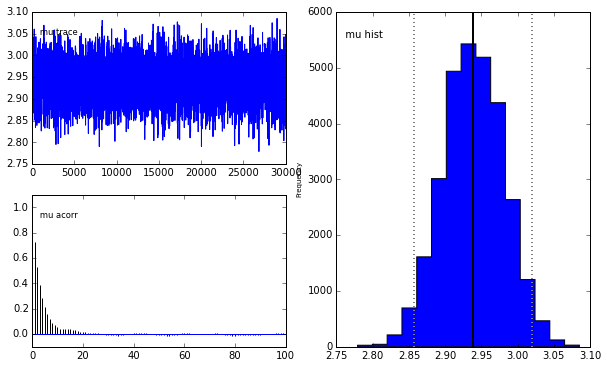

In [8]:
from pymc.Matplot import plot as mcplot

mcplot(mcmc)
plt.show()

The estimated value of the parameter is `2.9396811517572554`.  The standard deviation of the posterior distribution of $\mu$ is `0.041412844137324857`. 

#### Likelihood Approach

We have a convenient method to perform the likelihood approach for estimation of parameters of any distribution represented as a class in the submodule `scipy.stats`.  In our case, since we are fixing the standard deviation (the `scale` as parameter of the normal distribution for this particular class), we would issue

In [9]:
from scipy.stats import norm as NormalDistribution

NormalDistribution.fit(ratios.dropna(), fscale=1.3)

(2.9396857495543736, 1.3)


Giving us a similar value for the mean.  The graph of the (non-negative log) likelihood function for `mu` may be obtained as follows

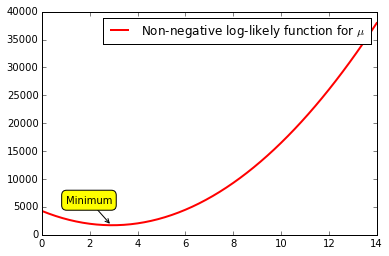

In [10]:
nnlf = lambda t: NormalDistribution.nnlf([t, 1.3], ratios.dropna())
nnlf = np.vectorize(nnlf)

x = np.linspace(0, 14)
plt.plot(x, nnlf(x), lw=2, color='r', label='Non-negative log-likely function for $\mu$')
plt.legend()
plt.annotate('Minimum', xy=(2.9, nnlf(2.9)), xytext=(0,20),
             textcoords='offset points', ha='right', va='bottom',
             bbox=dict(boxstyle='round,pad=0.5', fc='yellow',
                       color='k', alpha=1),
             arrowprops=dict(arrowstyle='->', color='k',
                             connectionstyle='arc3,rad=0'))
plt.show()

In any case, the result is visually what we would expect

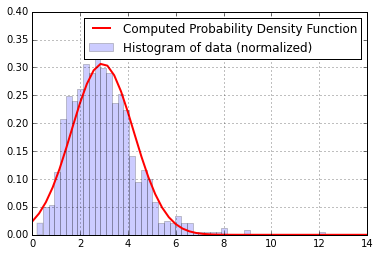

In [11]:
distribution = NormalDistribution(loc=2.9396857495543736, scale=1.3)

plt.plot(x, distribution.pdf(x), 'r-', lw=2, label='Computed Probability Density Function')
ratios.hist(bins=50, alpha=0.2, normed=True, label='Histogram of data (normalized)')
plt.legend()
plt.show()

### Interval Estimation

In this setting, we seek an interval of values for $\mu$ which are supported by the data.

#### Frequentist Approach

In the frequentist approach, we start by providing a small *confidence coefficient* $\alpha$, and proceed to find an interval so that the probability of including the parameter $\mu$ is $1-\alpha$.  In our example, we set $\alpha = 0.05$ (hence, the probability we impose is `0.95`), and proceed to compute the interval with the method `interval` of any class defining a continuous distribution in the module `scipy.stats`.

In [12]:
loc = ratios.mean()
scale= ratios.sem()
NormalDistribution.interval(0.95, scale=scale, loc=loc)

(2.8565615022044484, 3.0228099969042979)

According to this method, values of the average $\mu$ between `2.8565615022044484` and `3.0228099969042979` are consistent with the data based on a 95% confidence interval. 

#### Bayesian Approach

In the Bayesian Approach, the equivalent to the confidence interval is called a *credible region* (or interval), and is associated to the *highest posterior density region*---the set of most probably values of the parameter that, in total, constitute $100*(1-\alpha)$ of the posterior mass.  

Recall that when using a Markov chain Montecarlo, after a sampling we obtained the credible region for $\alpha = 0.05$.

To obtain credible intervals for other values of alpha, we use the routine `hpd` in the submodule `pymc.utils` directly.  For example, the highest posterior density region for $\alpha=0.01$ is computed as follows.


In [13]:
pm.utils.hpd(mcmc.trace('mu')[:], 1-.99)

array([ 2.83680427,  3.04834305])

#### Likelihood Approach

This is also done with the aid of the method `nnlf` of any distribution.  In this setting, we need to determine the interval of parameter values for which the likelihood exceeds $1/k$ where $k$ is either 8 (strong evidence) or 32 (very strong evidence).

The estimation of the corresponding interval is then a simple application of optimization.  We leave this as an exercise.